In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Best Params: (5, 50, 0.2, 0.05, 0.08)
Best Total Return: 0.3914
Running backtest with best params: short_ma=5, long_ma=50, profit_pct=0.2, loss_pct=0.05, trailing_stop=0.08
   Signal_Date         Action  Exec_Date  Exec_Price_Raw  Exec_Price_eff  \
31  2024-11-04           SELL 2024-11-05      220.772521      220.662135   
32  2024-11-20            BUY 2024-11-21      228.070382      228.184417   
33  2025-01-10  TRAILING STOP 2025-01-13      232.703929      232.587577   
34  2025-02-19            BUY 2025-02-20      244.341910      244.464081   
35  2025-03-04           SELL 2025-03-05      234.845157      234.727734   
36  2025-05-15            BUY 2025-05-16      212.119267      212.225327   
37  2025-05-22      STOP LOSS 2025-05-23      193.450453      193.353727   
38  2025-07-01            BUY 2025-07-02      208.673176      208.777513   
39  2025-08-05           SELL 2025-08-06      205.396898      205.294200   
40  2025-08-06            BUY 2025-08-07      218.631873      218.7

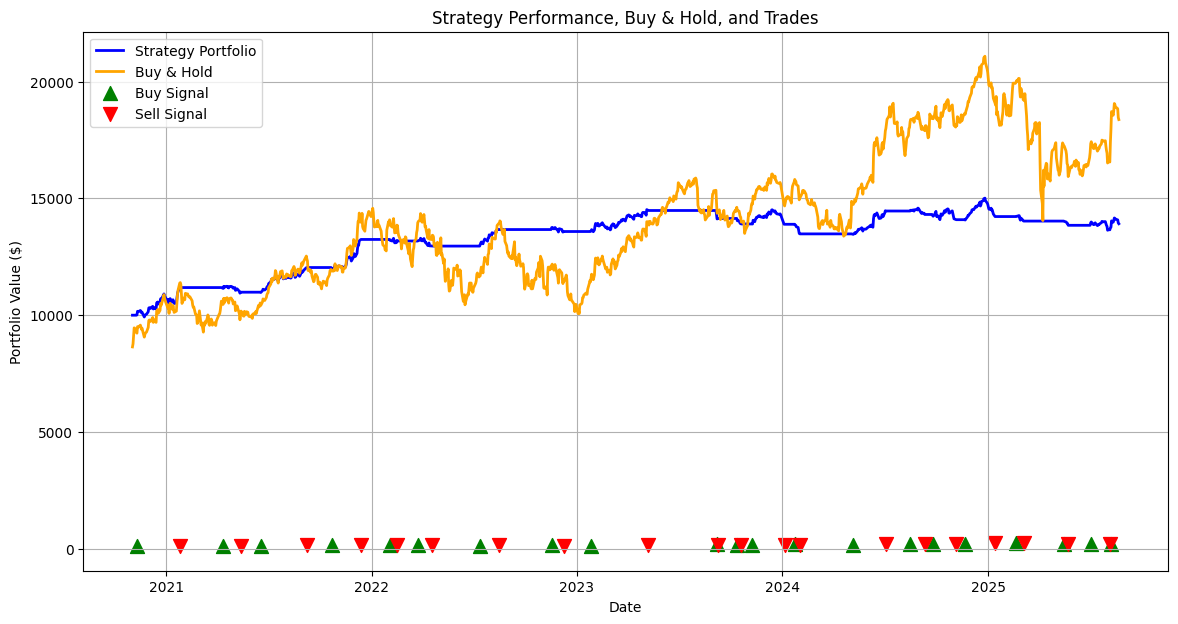

In [45]:
slippage_bps = 0.0005
commission_model = {
    "type": "flat_per_trade",
    "flat_fee":1.00,
    "per_share_fee":0.005,
    "pct_fee":0.0001
}
aloc_frac = 0.50
max_capital_frac = 0.80
vol_target = 0.10
vol_lookback = 30
eps = 1e-12
starting_cash = 10000
period="5y"


def effective_price(side, raw_px, slippage_bps=slippage_bps):
    if side == "BUY":
        return raw_px*(1 + slippage_bps)
    elif side == "SELL":
        return raw_px*(1 - slippage_bps)
    else :
        return ValueError("side must be buy or sell")

def commission_value(model, shares, px_eff):
    t = model["type"]
    if t == "flat_per_trade":
        return float(model.get("flat_fee", 0.0))
    elif t == "per_share":
        return float(model.get("per_share_fee", 0.0)) * float(shares)
    elif t == "percent_notional":
        return float(model.get("pct_fee", 0.0)) * float(shares) * float(px_eff)
    else :
        return ValueError("unknown commison model")

def buy_hold(ticker,period=period):
    df_buy_hold = yf.download(ticker, period=period, auto_adjust=True)
    df_buy_hold.columns = [col[0] if isinstance(col, tuple) else col for col in df_buy_hold.columns]
    shares_bh = starting_cash / df_buy_hold["Close"].iloc[0]
    df_buy_hold["BuyHold"] = shares_bh * df_buy_hold["Close"]
    return df_buy_hold
df_buy_hold = buy_hold("AAPL")
def run_backtest(ticker, period=period, short_ma = 5, long_ma = 50, profit_pct = 0.2,loss_pct = 0.05, trailing_stop = 0.07):
    # download the data
    df = yf.download(ticker, period=period, auto_adjust=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

    # calculate the rolling avg
    df["short_ma"] = df["Close"].rolling(window=short_ma).mean()
    df["long_ma"] = df["Close"].rolling(window=long_ma).mean()
    
    # define the signal
    df["Signal"] = 0
    df.loc[(df["short_ma"] > df["long_ma"]) & (df["short_ma"].shift(1) <= df["long_ma"].shift(1)), "Signal"] = 1  # Buy
    df.loc[(df["long_ma"] > df["short_ma"]) & (df["long_ma"].shift(1) <= df["short_ma"].shift(1)), "Signal"] = -1 # Sell

    # clean and execution price (next day open)
    df = df.dropna(subset=["short_ma", "long_ma"])
    df["ExecPrice"] = df["Open"].shift(-1)
    df = df.dropna(subset=["ExecPrice"])

    # staring portfolio
    cash = starting_cash
    shares_held = 0.0
    portfolio = []
    trades = []
    total_commission_paid = 0.0
    total_slippage_cost = 0.0
    peak_price = 0.0
    entry_price = 0.0

    daily_ret = df["Close"].pct_change()
    #print(daily_ret)
    df["anl_vol"] = daily_ret.rolling(vol_lookback).std() * np.sqrt(252)
    exp_flag = []

    for i in range(len(df)):
        current_price = df["Close"].iloc[i]
        signal = df["Signal"].iloc[i]
        exec_price = df["ExecPrice"].iloc[i]
        
        equity = cash + (shares_held * current_price)
        portfolio.append(equity)

        if shares_held > 0:
            exp_flag.append(1)
        else:
            exp_flag.append(0)

        if shares_held > 0:
            peak_price = (max(peak_price, current_price))

            if current_price <= entry_price*(1 - loss_pct):
                px_eff = effective_price("SELL", exec_price, slippage_bps)
                shares_to_sell = shares_held
                proceeds = shares_to_sell * px_eff
                comm = commission_value(commission_model, shares_to_sell, px_eff)

                cash += proceeds - comm
                shares_held = 0
                total_commission_paid += comm
                total_slippage_cost += (exec_price - px_eff) * shares_to_sell
                shares_delta = -shares_to_sell
                trades.append((df.index[i], "STOP LOSS", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
                entry_price = 0.0
                peak_price = 0.0
                continue

            elif current_price >= entry_price*(1+profit_pct):
                px_eff = effective_price("SELL", exec_price, slippage_bps)
                shares_to_sell = shares_held
                proceeds = shares_to_sell * px_eff
                comm = commission_value(commission_model, shares_to_sell, px_eff)

                cash += proceeds - comm
                shares_held = 0
                total_commission_paid += comm
                total_slippage_cost += (exec_price - px_eff) * shares_to_sell
                shares_delta = -shares_to_sell
                trades.append((df.index[i], "TAKE PROFIT", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
                entry_price = 0.0
                peak_price = 0.0
                continue

            elif current_price <= peak_price * (1 - trailing_stop):
                px_eff = effective_price("SELL", exec_price, slippage_bps)
                shares_to_sell = shares_held
                proceeds = shares_to_sell * px_eff
                comm = commission_value(commission_model, shares_to_sell, px_eff)

                cash += proceeds - comm
                shares_held = 0
                total_commission_paid += comm
                total_slippage_cost += (exec_price - px_eff) * shares_to_sell
                shares_delta = -shares_to_sell
                trades.append((df.index[i], "TRAILING STOP", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
                entry_price = 0.0
                peak_price = 0.0
                continue

    # Buy signal
        if signal == 1:
            fixed_frac = aloc_frac

            vol_today = df["anl_vol"].iloc[i]
            if pd.notna(vol_today) and vol_today > 0:
                vol_frac = vol_target / max(vol_today, eps)
            else :
                vol_frac = fixed_frac
        
            target_frac = min(fixed_frac, vol_frac, max_capital_frac)
            target_value = target_frac * equity
            px_eff = effective_price("BUY", exec_price, slippage_bps)
            target_shares = target_value / px_eff
            shares_delta = max(target_shares - shares_held, 0.0)
            comm = commission_value(commission_model, shares_delta ,px_eff)

            if shares_delta * px_eff + comm > cash:
                shares_delta = max((cash-comm)/px_eff, 0.0)
            if shares_delta == 0.0:
                comm = 0.0
        
            cash -= shares_delta * px_eff + comm
            shares_held += shares_delta
            total_commission_paid += comm
            total_slippage_cost += (px_eff - exec_price) * shares_delta

            trades.append((df.index[i], "BUY", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
            entry_price = exec_price
            peak_price = exec_price

    
    # Sell signal
        elif signal == -1 and shares_held > 0:
            px_eff = effective_price("SELL", exec_price, slippage_bps)
            shares_to_sell = shares_held
            proceeds = shares_to_sell * px_eff
            comm = commission_value(commission_model, shares_to_sell, px_eff)
        
            cash += proceeds - comm
            shares_held = 0
            total_commission_paid += comm
            total_slippage_cost += (exec_price - px_eff) * shares_to_sell
            shares_delta = -shares_to_sell
            trades.append((df.index[i], "SELL", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
            entry_price = 0.0
            peak_price = 0.0
    df["Portfolio"] = portfolio
    trades_df = pd.DataFrame(trades, columns=[
    "Signal_Date", "Action", "Exec_Date", "Exec_Price_Raw", "Exec_Price_eff", "Shares_After", "Cash_After", "commission", "shares_delta"
    ])
    #print(df[["Close", "short_ma", "long_ma", "Signal", "Portfolio"]].tail())
    buy_signals = df[df["Signal"] == 1]
    sell_signals = df[df["Signal"] == -1]
        
    return df, trades_df  # for now, just return the prepared frame

df, trades_df = run_backtest("AAPL")

def performance_metrics(portfolio_series):
    daily_ret = portfolio_series.pct_change()
    
    # Annualized volatility
    ann_vol = float(daily_ret.std() * np.sqrt(252))
    
    # CAGR
    years = (portfolio_series.index[-1] - portfolio_series.index[0]).days / 365
    cagr = float((portfolio_series.iloc[-1] / portfolio_series.iloc[0])**(1/years) - 1)
    
    # Sharpe ratio
    sharpe = float((daily_ret.mean() * 252) / ann_vol)
    
    # Maximum Drawdown
    cummax = portfolio_series.cummax()
    drawdown = (portfolio_series - cummax) / cummax
    max_dd = float(drawdown.min())
    
    # Total return
    total_return = float(portfolio_series.iloc[-1] / portfolio_series.iloc[0] - 1)
    
    return {
        "Max Drawdown": round(max_dd, 4),
        "Sharpe Ratio": round(sharpe, 4),
        "Annualized Volatility": round(ann_vol, 4),
        "CAGR": round(cagr, 4),
        "Total Return": round(total_return, 4)
    }

bt_metrics = performance_metrics(df["Portfolio"])
bh_metrics = performance_metrics(df_buy_hold["BuyHold"])

#print("Backtest Metrics:", bt_metrics)
#print("Buy & Hold Metrics:", bh_metrics)
#print(df.head())        # DataFrame with portfolio, signals, etc.
#print(trades_df.head()) # DataFrame with executed trades
'''
plt.figure(figsize=(14,7))

# Main axis: portfolio & buy & hold
plt.plot(df.index, df["Portfolio"], label="Strategy Portfolio", color="blue", lw=2)
plt.plot(df.index, df_buy_hold.loc[df.index, "BuyHold"], label="Buy & Hold", color="orange", lw=2)

# Plot trades
buy_trades = trades_df[trades_df["Action"]=="BUY"]
sell_trades = trades_df[trades_df["Action"].isin(["SELL","STOP LOSS","TAKE PROFIT","TRAILING STOP"])]

plt.scatter(buy_trades["Exec_Date"], buy_trades["Exec_Price_eff"], marker="^", color="green", s=100, label="Buy Signal")
plt.scatter(sell_trades["Exec_Date"], sell_trades["Exec_Price_eff"], marker="v", color="red", s=100, label="Sell Signal")
# Labels and legend
#plt.yscale("log")
plt.title("Strategy Performance, Buy & Hold, and Trades")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)

# Combine legends
lines, labels = plt.gca().get_legend_handles_labels()
plt.legend()
plt.show()
'''
# finding the bes parameter
short_ma_list = [5, 10, 20, 50]
long_ma_list = [50, 100, 150, 200]
profit_pct_list = [0.1, 0.2, 0.25, 0.3]
loss_pct_list = [0.05, 0.1,0.15, 0.2]
trailing_pct_list = [0.06,0.07,0.08]

best_params = None
best_metric = -np.inf

for s in short_ma_list:
    for l in long_ma_list:
        if s >= l: continue
        for p in profit_pct_list:
            for q in loss_pct_list:
                for t in trailing_pct_list:

                    df_check, trades_check = run_backtest("AAPL", short_ma=s, long_ma=l, profit_pct=p, loss_pct=q, trailing_stop=t)
                    metrics = performance_metrics(df_check["Portfolio"])
                    if metrics["Total Return"] > best_metric:
                        best_metric = metrics["Total Return"]
                        best_params = (s, l, p, q, t)

print("Best Params:", best_params)
print("Best Total Return:", best_metric)

s_best, l_best, p_best, q_best, t_best = best_params
print(f"Running backtest with best params: short_ma={s_best}, long_ma={l_best}, "
      f"profit_pct={p_best}, loss_pct={q_best}, trailing_stop={t_best}")

df_best, trades_best = run_backtest("AAPL", short_ma=s_best, long_ma=l_best, 
                       profit_pct=p_best, loss_pct=q_best, trailing_stop=t_best)
print(trades_best.tail(10))
print(df_best.tail(10))        
metrics_best = performance_metrics(df_best["Portfolio"])
print("Best Metrics:", metrics_best)
print("Buy & Hold Metrics:", bh_metrics)

plt.figure(figsize=(14,7))

# Main axis: portfolio & buy & hold
plt.plot(df_best.index, df_best["Portfolio"], label="Strategy Portfolio", color="blue", lw=2)
plt.plot(df_best.index, df_buy_hold.loc[df_best.index, "BuyHold"], label="Buy & Hold", color="orange", lw=2)

# Plot trades
buy_trades = trades_best[trades_best["Action"]=="BUY"]
sell_trades = trades_best[trades_best["Action"].isin(["SELL","STOP LOSS","TAKE PROFIT","TRAILING STOP"])]

plt.scatter(buy_trades["Exec_Date"], buy_trades["Exec_Price_eff"], marker="^", color="green", s=100, label="Buy Signal")
plt.scatter(sell_trades["Exec_Date"], sell_trades["Exec_Price_eff"], marker="v", color="red", s=100, label="Sell Signal")
# Labels and legend
#plt.yscale("log")
plt.title("Strategy Performance, Buy & Hold, and Trades")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)

# Combine legends
lines, labels = plt.gca().get_legend_handles_labels()
plt.legend()
plt.show()